In [4]:
import pandas as pd #used handling datasets (loading, transforming)
from sklearn.preprocessing import StandardScaler #scaling numeric features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #baseline ML model (linear regression model)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score #for evaluation
import matplotlib.pyplot as plt
import shap


In [5]:
df = pd.read_csv("/Users/ampatel/Downloads/Purdue/2025-26/credit-card-fraud/data/creditcard.csv")

In [6]:
X = df.drop('Class', axis=1) #X = all columns except class
y = df['Class'] #Y = just the class column with 0 = normal and 1 = fraud

# Split data into 80% training data and 20% testing data
# Training Data - model uses this data to learn from - “Train yourself on these examples and learn what makes something fraud.”
# Testing Data - used similarily to test cases - “Okay model, now let’s see how well you can predict fraud in new data.”

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#stratify=y keeps the same fraud/normal ratio in both sets
#random_state makes results able to be repeated

In [7]:
from sklearn.model_selection import train_test_split #made for splitting datasets into testing and training sets
scaler = StandardScaler() #creates scaler object

X_train[['Amount', 'Time']] = scaler.fit_transform(X_train[['Amount', 'Time']])

X_test[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])

# Amount - how much money was spent in the transaction
# Time - when the transaction happened
# model can get confused when it deals with big numbers, so we use the scaler to scale the numbers to be in roughly the same range
# fit_transform(): fit = learn the mean/std from the training data; transform = use that info to scale the numbers (centered around 0 and usually within -1 to +1)
# “Look at the Amount and Time columns in the training data, learn their average and range, and replace them with scaled versions so they’re normalized"

# X_test = “Use the same scaling formula from training data to scale the test data — don’t re-learn new values”
# fit_transform() -> used only on training data (learn + apply)
# transform() -> used on test data (apply only) 

In [8]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

#LogsiticRegression is a basic, but strong model
# max_iter=1000: allow up to 1000 loops to find best solution
#class_weight='balanced': pay extra attention to rare fraud cases
#random_state: keep things reproducible

model.fit(X_train, y_train) # Teaches the model using the training data

y_pred = model.predict(X_test) # asks the model to guess fraud(1) or normal(0) for the test data

In [9]:
print(classification_report(y_test, y_pred))
#Prints numbers that represent how well the tests performed
#Precision - how many were really frauds from the ones we said are frauds
#Recall - of the actual frauds, how many did we find
#Support - how many examples in each class

print(confusion_matrix(y_test, y_pred))
#Confusion matrix:
#top-left: correct normal
#top-right: missed frauds
#bottom-left = false alarms
#bottom-right: correct frauds

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

[[55478  1386]
 [    8    90]]


# Row 0:
Precision = 1.00 -> when model says "normal", it is 100% correct

Recall = 0.98 -> found 98% of normal transactions correctly

F1-score = 0.99 -> 98% balance between precision and recall

Support = 56864 -> 56,864 normal transactions

# Row 1:
Precision = 0.06 -> only 6% of transactions the model said were "fraud" were actually fraud -> means many normal transactions are being flagged incorrectly

Recall = 0.92 -> caught 92% of the real fraud cases

F1-score = 0.11 -> bc precision is low, combined score stays low

Support = 98 -> 98 fraud transactions in the test data


Accuracy was 98%, but is misleading because the dataset is imbalanced

Macro Avg - Average of precision, recall, f1-score across classes (treats both 0 and 1 equally)

Weighted Avg - gives more importance to the larger class, i.e., “normal”

In [10]:
y_prob = model.predict_proba(X_test)[:,1]
y_prob[:10]

array([5.84217499e-03, 6.91807539e-02, 1.34038414e-04, 1.51594735e-02,
       9.45210150e-01, 1.38826400e-02, 8.65657883e-04, 2.70837079e-02,
       6.60338904e-02, 4.58525157e-03])

In [11]:
from imblearn.over_sampling import SMOTE #Tool that makes fake fraud sample so classes are  balanced
from sklearn.ensemble import RandomForestClassifier # A tool made of many decision trees
from sklearn.metrics import classification_report, confusion_matrix

# SMOTE = Synthetic Minority Over-sampling Technique

In [12]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
y_train_res.value_counts()

Class
0    227451
1    227451
Name: count, dtype: int64

In [13]:
rf_model = RandomForestClassifier(n_estimators=200, #Make 50 trees (more trees = slower but better)
                                  random_state=42, #results can repeatedly reproduce
                                  n_jobs=-1, #use all CPU cores to train faster
                                  class_weight='balanced') #still pay attention to rare frauds


In [14]:
rf_model.fit(X_train_res, y_train_res)      # Train the Random Forest on the balanced data
y_pred_rf = rf_model.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56851    13]
 [   16    82]]


In [16]:
#Precision of Row 1 -> 86% of frauds were correct
#Recall of Row 1 -> 84% of frauds were found
#F1-score Row 1 -> 85% balanced between precision and recall which is very good
#Support of Row 1 -> 98 real frauds in the test case

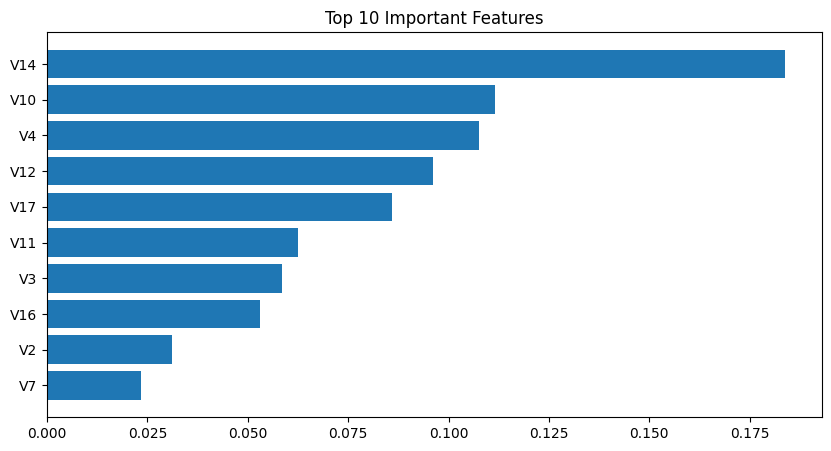

In [17]:
#Features -> information (columns) that the model looks at to make predictions
importances = rf_model.feature_importances_ #get important features
feature_names = X.columns #get the column names

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

#Sort the table so that the important features are at the top
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,5)) #Makes the chart frame bigger
plt.barh(feat_imp['Feature'][:10], feat_imp['Importance'][:10]) #Draws the horizontal bars for the graph
plt.gca().invert_yaxis() #flips the y-axis so that the bars are horizontal
plt.title("Top 10 Important Features") #gives the plot a title
plt.show() #prints out the graph

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import shap #library to explain why the model makes certain predicitions

In [19]:
y_scores = rf_model.predict_proba(X_test)[:, 1]

# predict_proba() gives two probabilities for each transaction
# Column 0 = normal -> probability of not fraud
# Column 1 = fraud -> probability of fraud

In [21]:
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

#precision_recall_curve -> how the model’s predictions behave at different cutoff points
#tells you how your fraud detection model’s accuracy and completeness change as you adjust how strict your “fraud” cutoff is

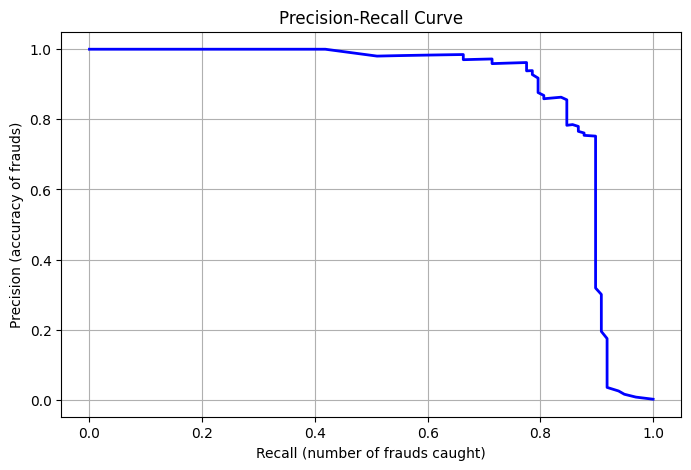

In [22]:
plt.figure(figsize=(8,5))
plt.plot(recall, precision, color="blue", linewidth=2)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall (number of frauds caught)")
plt.ylabel("Precision (accuracy of frauds)")
plt.grid(True)
plt.show()


In [23]:
# The closer the curve hugs the top-right, the better
# we want both high recall and high precision

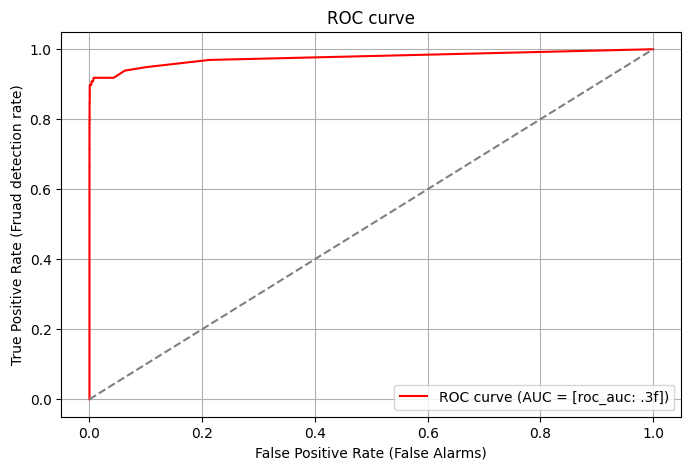

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores) #computing false positive and true positive rates

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color="red", label=f"ROC curve (AUC = [roc_auc: .3f])")
plt.plot([0,1], [0,1], color="gray", linestyle='--')
plt.xlabel("False Positive Rate (False Alarms)")
plt.ylabel("True Positive Rate (Fruad detection rate)")
plt.title("ROC curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create the SHAP explainer (uses TreeExplainer for tree-based models like RandomForest)
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test)